# Calculate DMD Mode Clusters (sDMD version)

***

This notebook should be run after calculating the DMD modes in the notebook `1_Calculate_DMD`. It hierarchically clusters DMD modes, assigns them into flat clusters, and plots the corresponding output modes.

Note that there are two versions of this notebook: a **gDMD** and **sDMD** version. These notebooks are nearly identical except that their default parameters have been chosen to be more appropriate for each case.

In [1]:
%load_ext watermark
%watermark -a "James Kunert-Graf" -d -v -m -p os,h5py,tqdm,numpy,matplotlib,scipy -g -u

James Kunert-Graf 
last updated: 2018-04-25 

CPython 2.7.12
IPython 5.6.0

os n
h5py 2.7.0
tqdm 4.11.2
numpy 1.14.2
matplotlib 2.0.2
scipy 1.0.0

compiler   : GCC 5.4.0 20160609
system     : Linux
release    : 4.4.0-119-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 12
interpreter: 64bit
Git hash   : 0be1fc485c9d84cbd56a683784f53454e09b00f1


/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import os
import h5py
from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as ssd

from hcp_dmd_utils import flat2mat,mat2flat

%matplotlib inline

## Parameters and Filepaths

***

The cell below contains parameters for the execution of the algorithm, along with variables specifying which data to analyze

**Parameters**

-  *mthresh*: threshold on spatial continuity measure which filters out discontinuous modes before clustering
-  *zthresh*: threshold on 
-  *min_clust_size*: clusters containing fewer than this number of modes are not kept for visualization
-  *fclust_thresh*: threshold on flat clustering using `scipy.cluster.hierarchy.fcluster`

**Filepath Information**

The set of runs to analyze is identified using the same labels as were used in `1_Calculate_DMD`, which should be run first as this notebook relies on its saved output.
-  *runlabel*: run label to analyze (e.g. REST1, REST2)
-  *scandir*: scan direction to analyze (LR/RL)
-  *nmodes*: choice of *nmodes* parameter used in DMD calculation (number of modes calculated in each window)
-  *nframes*: choice of *nframes* parameter used in DMD calculation (window length, in frames)
-  *ulist*: individual to analyze in sDMD

In [3]:
##CLUSTERING PARAMETERS:
mthresh=15
zthresh=3.5
min_clust_size=20
fclust_thresh=0.95

## SCAN TO CLUSTER
runlabel='REST1'
scandir='LR'
nmodes=8
nframes=32
# Choose individuals to include in clustering:
u120=np.genfromtxt('u120.txt').astype(int).astype(str)
u=u120[0]

### Reference RSNs
***
We use reference RSNs from Gordon et al. ("Generation and evaluation of a cortical area parcellation from resting-state correlations", *Cerebral Cortex*, 26(1):288–303, 2016.). We load them here and convert them into a vector form where we can easily compare them against our average modes.

In [4]:
#load RSN masks and labels
with h5py.File('RSN.h5','r') as hf:
    RSNs=np.array(hf['RSNs'])
    RSNlabels=np.array(hf['RSNlabels'])

rsn=[]        
for k in range(RSNs.shape[2]):
    r=RSNs[:,:,k]
    rsn.append(mat2flat(r))
rsn=np.vstack(rsn)
rsnNo=np.arange(RSNs.shape[2])
rsnNo=np.delete(rsnNo,[0,7])
rsn=rsn[rsnNo,:]
rlabs=RSNlabels[rsnNo]

## Calculate Clusters for DMD

**Load DMD modes**:

Load and collect DMD mode information for the scan and set of individuals identified above.

In [5]:
try:
    os.mkdir('./DMD_Clusters/')
except:
    pass
try:
    os.mkdir('./DMD_Clusters/sDMD/')
except:
    pass
try:
    os.mkdir('./Figures/')
except:
    pass
try:
    os.mkdir('./Figures/sDMD/')
except:
    pass
freq=[]
power=[]
F=[]
ux=[]
jx=[]
jno=[]

#LOAD WINDOWED DMD RESULTS
rx=[]
runNo=-1

fdir='./DMD_results/nmodes{:}_nframes{:}_{:}_{:}/'.format(nmodes,nframes,runlabel,scandir)
try:
    with h5py.File(fdir+'Modes_{:}.h5'.format(u),'r') as hf:
        F.append(np.array(hf['F']))
    with h5py.File(fdir+'{:}.h5'.format(u),'r') as hf:            
        freq.append(np.array(hf['freq']))
        power.append(np.array(hf['power']))
        ux.append(np.array(hf['ux']))
        jx.append(np.array(hf['jx']))
        jno.append(np.array(hf['jno']))
        runNo+=1
        rx.append(runNo*np.ones(np.array(hf['jx']).shape))
except:
    pass

freq=np.hstack(freq)
power=np.hstack(power)
F=np.vstack(F)
ux=np.hstack(ux);
jx=np.hstack(jx)
rx=np.hstack(rx)
jno=np.hstack(jno)
winNo=np.unique(np.array(['{:03.0f}{:03.0f}{:01.0f}'.format(ux[k],jx[k],rx[k]) for k in range(len(ux))]),return_inverse=True)[1]


**Pre-clustering mode filtration**:

Filter out modes which do not meet a certain standard of spatial continuity (threshold set above by parameter 'mthresh'). Then, filter out modes for which no pixel has a z-score above the threshold zthresh.

We also calculate the 'overlap' array, which is the dot product between the DMD modes and the RSN masks. This gives a measure of how much of each DMD mode's power is concentrated inside of a particular reference RSN (roughly indicating how strongly a mode resembles a given RSN).

In [6]:
#CALCULATE/THRESHOLD ON SPATIAL CONTINUITY
Mflat=(F-np.mean(F,1)[:,None])/F.std(1)[:,None]
mpro=[]
for f in Mflat:
    m=flat2mat(f>2.0).astype(float)
    #mpro: product of masks with masks which have been shifted diagonally
    mpro.append(np.sum(np.sum(m[1:,1:]*m[:-1,:-1],0),0))
mpro=np.hstack(mpro) 
mwhere=mpro>mthresh

#convert modes to zscores and threshold to create masks to cluster
Fz=F[mwhere,:]
Fz=(Fz-np.mean(Fz,1)[:,None])/np.std(Fz,1)[:,None]
Fn=(Fz>zthresh).astype(float)

#calculate overlap between mode masks and rsn masks
overlap=rsn.dot(Mflat.T)

**Clustering**:

Hierarchically cluster the modes using `scipy.cluster.hierarchy`. Heuristically, hierarchically clustering upon the average correlation works well, though this could be adjusted below.

Flat clusters are then formed based upon the "fclust_thresh" parameter defined above. 



In [7]:
#cluster modes based upon average correlation between groups
method='average';metric='correlation';
Z=sch.linkage(Fn, method, metric)
ix=sch.dendrogram(Z,no_plot=True)['leaves']
#form flat clusters
cgroups=sch.fcluster(Z,fclust_thresh,'distance')[ix]
cgroups=cgroups.astype(float)

#count the number of modes belonging to each cluster, and remove clusters with less than 'min_clust_size' members
cun,count=np.unique(cgroups,return_counts=True)
for k,c in enumerate(cun):
    if count[k]<min_clust_size:
        cgroups[cgroups==c]=-1

cgroups=np.unique(cgroups,return_inverse=True)[1].astype(float)
cgroups[cgroups==0]=np.nan
cgroups+=-1

#cif = 
cif=np.isfinite(cgroups)
cuni=np.unique(cgroups[cif])



In [8]:
#get identified clusters in terms of original indices
#so that they can be easily reloaded in the future...
outfile='./DMD_Clusters/sDMD/{:}_{:}_{:}_{:}m_{:}f_{:}clusters2.h5'.format(u,runlabel,scandir,nmodes,nframes,len(cuni))
indices=np.arange(len(jx))[mwhere][ix]
cluster_indices=[]
for c in cuni:
    cix=indices[cgroups==c]
    cluster_indices.append(cix)
print '{:} clusters'.format(len(cuni))

#sort the RSN overlap array by hierarchical clustering order
Ou=overlap[:,mwhere][:,ix][:,cif]
Ou=(Ou-Ou.mean(1)[:,None])/Ou.std(1)[:,None]


7 clusters


In [9]:
import skimage.transform as skit
#'scale_factor' is a factor to scale down plotted image size -- use for many thousands of modes
scale_factor=1
Fsub=skit.downscale_local_mean(Fn[ix][cif],(scale_factor,1))
C=ssd.cdist(Fsub,Fsub,metric=metric)
C=np.abs(1-C);
np.fill_diagonal(C,0)

### Figure
***
Plot a figure showing the hierarchically clustered correlation matrix, the overlap of each mode with canonical RSNs, the automatically identified flat clusters, and the average DMD mode within each cluster:

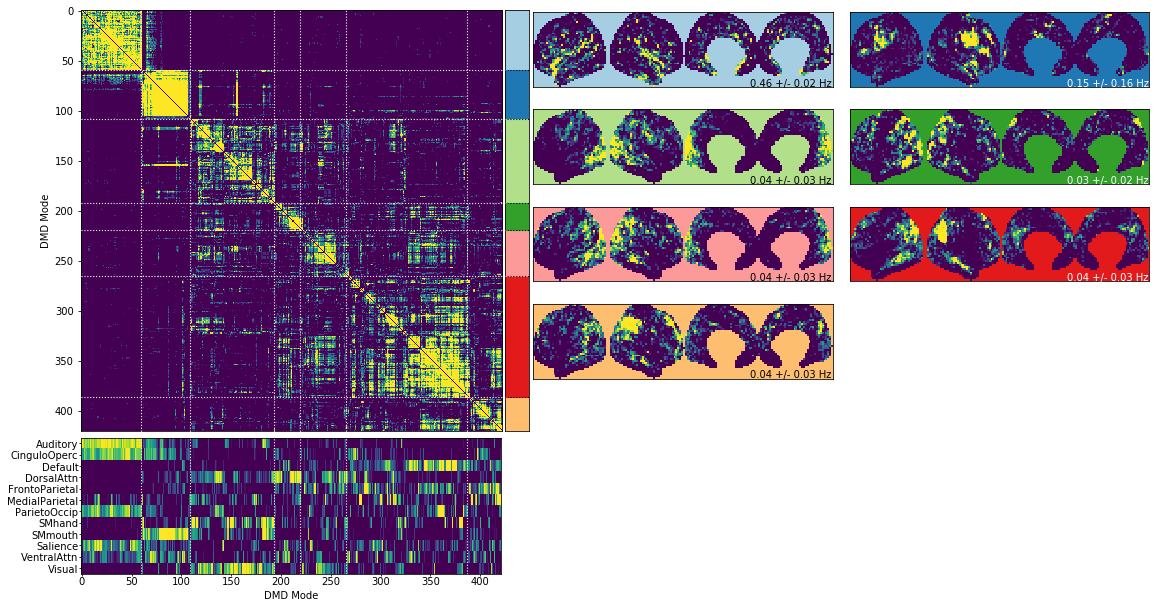

In [10]:
plt.figure(figsize=(16,9))

a1=plt.subplot2grid((6,1),(0,0))    
plt.imshow(C,vmin=C.mean(),vmax=C.mean()+2.0*C.std())
yl=plt.ylim()
plt.ylim(yl)
plt.xticks([])
plt.ylabel('DMD Mode')

a2=plt.subplot2grid((6,1),(1,0))
vmin=Ou.mean();vmax=Ou.mean()+2.0*Ou.std()
plt.imshow(skit.downscale_local_mean(Ou,(1,scale_factor)),aspect='auto',vmin=vmin,vmax=vmax)
plt.yticks(np.arange(len(rlabs)),rlabs,rotation=0)
a2.tick_params(pad=1,length=2)
xl=plt.xlim()
plt.xlim(xl)
plt.xlabel('DMD Mode')


a4=plt.subplot2grid((6,1),(2,0))
cbig=np.ones(cgroups.shape)*np.nan
ck=-1
for c in cuni:
    if np.sum(cgroups==c)>=min_clust_size:
        ck+=1
        cbig[cgroups==c]=ck
plt.imshow(cbig[cif][:,None]%12,cmap='Paired',aspect='auto',vmin=0,vmax=12)
plt.xticks([]);plt.yticks([])

a5=plt.subplot2grid((6,1),(3,0),frameon=False)
lplot=np.where(cbig[cif][1:]!=cbig[cif][:-1])[0].astype(float)/(C.shape[0]*scale_factor)
cut=0.95
for lp in lplot:
    plt.plot([0,cut],[lp]*2,':',c=[1,1,1],lw=1.1)
    plt.plot([cut,1],[lp]*2,':',c=[0,0,0],lw=1.1)
plt.xlim([0,1])
plt.ylim([0,1])
plt.xticks([])
plt.yticks([])
a5.invert_yaxis()

a6=plt.subplot2grid((6,1),(4,0),frameon=False)
lplot=np.where(cbig[cif][1:]!=cbig[cif][:-1])[0].astype(float)/(C.shape[0]*scale_factor)
cut=0.95
for lp in lplot:
    plt.plot([lp]*2,[0,1],':',c=[1,1,1],lw=1.1)
plt.xlim([0,1])
plt.ylim([0,1])
plt.xticks([])
plt.yticks([])

x1=0.0578
y1=0.3
y2=0.08
w1=0.364
a1.set_position([0.00,y1,0.48,0.65])
a2.set_position([x1,y2,w1,0.21])    
a4.set_position([0.426,y1,0.025*0.8,0.65])
a5.set_position([x1,y1,w1+0.025,0.65])
a6.set_position([x1,y2,w1,0.87])
glist=np.unique(cgroups[np.isnan(cgroups)==False]).astype(int)

#%
cf=[]
for gid in glist:
    cf.append(np.mean(np.absolute(freq[mwhere][ix][cgroups==gid])))
cf=np.array(cf)


glist_big=[]
for gid in glist:
    if np.sum(cgroups==gid)>=min_clust_size:
        glist_big.append(gid)
glist_big=np.array(glist_big)
DMN=[]
for gk,gid in enumerate(glist_big):
    a6=plt.axes([0.45+0.275*(gk%2),0.714-0.15*np.floor(gk/2),0.26,0.35])
    colors=mpl.cm.Paired(range(12))
    a6.set_facecolor(colors[gk%12])
    dmn=np.mean(F[mwhere][ix][cgroups==gid],0)
    vmin=dmn.mean()+0.0*dmn.std();vmax=dmn.mean()+2.0*dmn.std()
    DMN.append(dmn)
    D=flat2mat(dmn)
    D[D==0]=np.nan
    D=np.concatenate((D[:40],D[40:]),1)
    cm=mpl.cm.viridis
    cm.set_bad([1,1,1,0])
    plt.imshow(D,vmin=vmin,vmax=vmax,cmap=cm)
    plt.xticks([]);plt.yticks([])

    cf=freq[mwhere][ix][cgroups==gid]
    lum=np.sum(np.array([0.299,0.587,0.114])*colors[gid%12][:3])
    if lum>0.65:
        tcolor=[0,0,0]
    else:
        tcolor=[1,1,1]
    plt.text(159,40,'{:0.2f} +/- {:0.2f} Hz'.format(cf.mean(),cf.std()),color=tcolor,ha='right',va='bottom')

DMN=np.vstack(DMN)
plt.savefig('./Figures/sDMD/fig2b_{:}_{:}_modes.svg'.format(u,runlabel,scandir))

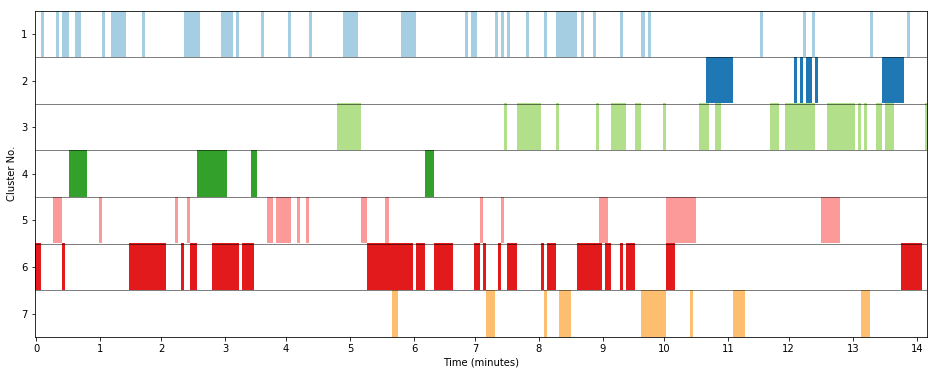

In [17]:
frame_shift=4
tstep=(14*60+33.)/1200*frame_shift
cuni=np.unique(cbig[np.isfinite(cbig)])
juni=np.unique(jx)
T=np.ones((len(cuni),len(juni)))*np.nan
for c in cuni.astype(int):
    jc=jx[mwhere][ix][cbig==c].astype(int)
    T[c,jc]=c
    
plt.figure(figsize=(16,6))
plt.imshow(T,aspect='auto',cmap='Paired',vmax=12,vmin=0)
plt.ylabel('Cluster No.')
plt.xlabel('Time (minutes)')
#%
plt.yticks(np.arange(len(cuni)),np.arange(len(cuni))+1)
linep=np.arange(len(cuni)-1)
xl=plt.xlim()
yl=plt.ylim()

for lp in linep:
    plt.plot(xl,[lp+0.5]*2,c=[0,0,0],lw=0.5)
    #pass
plt.xlim(xl)
tix=np.round(np.arange(0,14*60+30,60)/tstep)
plt.xticks(tix,np.round(tix*tstep/60).astype(int))
plt.savefig('./Figures/sDMD/fig2b_{:}_{:}_time.svg'.format(u,runlabel,scandir))

### Output
***
Save the following: the generated figure; the indices of the modes which constitute each of the plotted clusters; the average mode within each cluster.

In [18]:
with h5py.File(outfile,'w') as hf:
    dt = h5py.special_dtype(vlen=np.dtype('int32'))
    hf.create_dataset('clusters',data=np.array(cluster_indices),dtype=dt)
    hf.create_dataset('modes',data=DMN)